In [1]:
# Import
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import optuna
import torch.utils.tensorboard as tb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

d:\OneDrive\Documents\GitHub\DLProject_1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


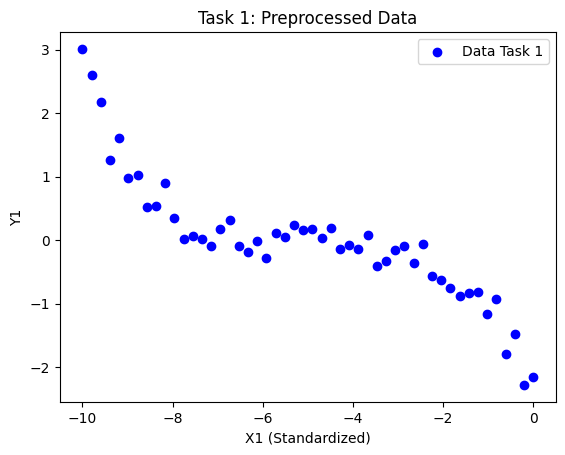

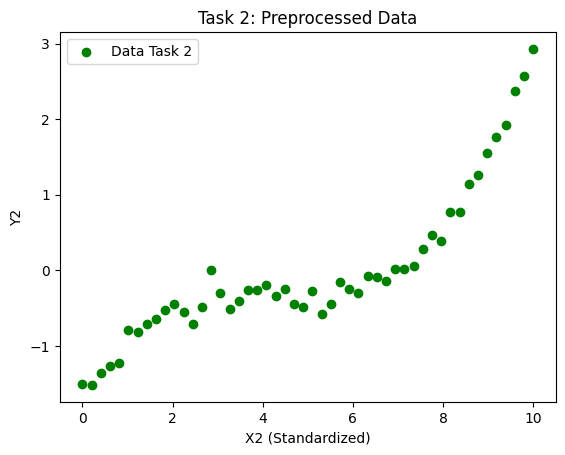

In [2]:
class DataSet:
    def __init__(self, x1, y1, x2, y2, x_combine, y_combine):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.x_combine = x_combine
        self.y_combine = y_combine


    def poly1(x):
        return -2*x**3 + x**2 + 3*x + 6

    def poly2(x):
        return 3*x**3 + 6*x**2 - 10


    def data_generator(data_size=50, noise_std=20.5, seed=42):
        # Set the random seed for reproducibility
        torch.manual_seed(seed)
        
        x1 = torch.linspace(-10, 0, steps=data_size)
        x2 = torch.linspace(0, 10, steps=data_size)
        y1 = DataSet.poly1(x1 + 5)
        y2 = DataSet.poly2(x2 - 5)

        noisy_y1 = y1 + torch.randn_like(y1) * noise_std
        noisy_y2 = y2 + torch.randn_like(y2) * noise_std

        # Normalize the data on the y-axis only
        scaler_y1 = StandardScaler().fit(noisy_y1.unsqueeze(1).numpy())
        scaler_y2 = StandardScaler().fit(noisy_y2.unsqueeze(1).numpy())

        y1_norm = torch.tensor(scaler_y1.transform(noisy_y1.unsqueeze(1)), dtype=torch.float32).squeeze(dim=1)
        y2_norm = torch.tensor(scaler_y2.transform(noisy_y2.unsqueeze(1)), dtype=torch.float32).squeeze(dim=1)

        x_combined = torch.cat((x1, x2), dim=0)
        y_combined = torch.cat((y1_norm, y2_norm), dim=0)

        return DataSet(x1, y1_norm, x2, y2_norm, x_combined, y_combined)

dataset = DataSet.data_generator(data_size=50, noise_std=20.5, seed=42)

# Plot the preprocessed data for Task 1
plt.scatter(dataset.x1, dataset.y1, color='blue', label='Data Task 1')
plt.xlabel('X1 (Standardized)')
plt.ylabel('Y1')
plt.title('Task 1: Preprocessed Data')
plt.legend()
plt.show()

# Plot the preprocessed data for Task 2
plt.scatter(dataset.x2, dataset.y2, color='green', label='Data Task 2')
plt.xlabel('X2 (Standardized)')
plt.ylabel('Y2')
plt.title('Task 2: Preprocessed Data')
plt.legend()
plt.show()

    

In [3]:
# Model definition
class DynamicLinearRegression(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super(DynamicLinearRegression, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.hidden_layers.append(nn.Linear(1, num_nodes[i]))
            else:
                self.hidden_layers.append(nn.Linear(num_nodes[i-1], num_nodes[i]))
        self.output = nn.Linear(num_nodes[-1], 1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x  

In [4]:
# run = neptune.init_run(
#     project="tuancao749/DLProject1",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NjUyZGRmNi1mYjliLTQ2MjItODcyZS1lMWFkNzdkYWRmMmYifQ==",
# )

writer = tb.SummaryWriter()

class Objective:
    def __init__(self, x1, x2, isPlot=True) -> None:
        self.isPlot = isPlot
        self.x1 = x1
        self.x2 = x2

    def __call__(self,trial):
        lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        num_epochs = 1000
        num_layers = trial.suggest_int('num_layers', 1, 6)
        layer_nodes = [trial.suggest_int(f'layer_{i}_nodes', 1, 10) for i in range(num_layers)]
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # run['Trial_{}/Hyperparameters'.format(study.trials[-1].number)] = {
        #         'Learning Rate': lr,
        #         'Number of Layers': num_layers,
        #         'Layer Nodes': layer_nodes
        #     }
        
        total_loss = 0.0
        for i, (train_index, val_index) in enumerate(kf.split(self.x1)):
            train_x, train_y = self.x1[train_index], self.y1[train_index]
            val_x, val_y = self.x1[val_index], self.y1[val_index]

            model = DynamicLinearRegression(num_layers, layer_nodes)
            loss_fnc = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            for epoch in range(num_epochs):
                outputs = model(train_x.unsqueeze(1))
                loss = loss_fnc(outputs, train_y.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # run[f'Trial_{study.trials[-1].number}/Fold_{i}/Training_Loss'].append(step=epoch, value=loss.item())

            with torch.no_grad():
                val_outputs = model(val_x.unsqueeze(1))
                val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))
            total_loss += val_loss.item()


            # run['Trial_{}/Validation_Loss'.format(study.trials[-1].number)].append(val_loss.item())
            
            if self.isPlot: 
                #Plot for each Fold
                plt.figure(figsize=(10, 6))
                plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
                plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
                with torch.no_grad():
                    predicted_y = model(self.x1.unsqueeze(1)).numpy()
                    plt.plot(self.x1.numpy(), predicted_y, label='Predicted Function', color='green')
                plt.title(f'Noisy Data Points around Cubic Function, loss = {val_loss.item()}')
                plt.xlabel('x')
                plt.ylabel('y')
                plt.legend()
                plt.grid(True)
                #plt.savefig(f'img/trial_{study.trials[-1].number}_Fold_{i}.png') 
                #fig = plt.gcf()
                #plt.close()

                #description = f'Trial: {study.trials[-1].number}, Fold: {i}, Loss: {val_loss.item()}'
                # run[f"Trial_{study.trials[-1].number}/Prediction_Examples"].append(value=fig, name=f'Trial_{study.trials[-1].number}_Fold_{i}', description=description, step=int(i))




        return total_loss / 10



    # run['Best_Parameters'] = best_params
    # run['Best_Value'] = best_value

    # # End Neptune run
    # run.stop()

### Fisher Information Matrix (FIM)

This formula represents the Fisher Information Matrix, which quantifies the importance of each parameter based on the expectation of the squared gradient of the log-likelihood:

$$
F_{jj} = \mathbb{E} \left[ \left( \frac{\partial \log p(y|x; \theta)}{\partial \theta_j} \right)^2 \right]
$$

### Approximation of the Fisher Information Matrix

In practice, this expectation is approximated by averaging over a finite dataset:

$$
F_{jj} \approx \frac{1}{N} \sum_{i=1}^{N} \left( \frac{\partial L_{task}}{\partial \theta_j} \right)^2
$$

Here, $L_{task}$ is the loss for the current task, and $N$ is the number of data points.


In [5]:
# EWC class definition
class EWC:
    # Contructor
    def __init__(self, model, data):
        self.model = model
        self.data = data
        # Create an important params dictionary (exclude non-learnable parameters)
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._calculate_fisher()

        for n, p in self.params.items():
            self.params[n] = p.clone().detach()

    def _calculate_fisher(self):
        precision_matrices = {n: torch.zeros(p.size()) for n, p in self.params.items()}
        self.model.eval()
        for x, y in self.data:
            self.model.zero_grad()
            output = self.model(x)
            loss = nn.MSELoss()(output, y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision_matrices[n] += (p.grad ** 2) / len(self.data)
        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self.params[n]) ** 2
            loss += _loss.sum()
        return loss


In [6]:
# Training function with EWC first Task
def train_model_with_ewc(model, dataset, ewc=None, lr=0.001, epochs=1000, lambda_ewc=1000):
    
    if ewc is None:
        x = dataset.x1
        y = dataset.y1
    else:
        x = dataset.x2
        y = dataset.y2


    train_x, val_x, train_y, val_y = train_test_split(x, y, random_state=42)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):       
        outputs = model(train_x.unsqueeze(1))
        loss = loss_fn(outputs, train_y.unsqueeze(1))
        optimizer.zero_grad()
        if ewc is not None:
            ewc_loss = ewc.penalty(model)
            print(f'ewc_loss :{ewc_loss.item()}')
            print(f'loss before: {loss.item()}')
            loss += lambda_ewc * ewc_loss
            print(f'loss after: {loss.item()}')
        loss.backward()
        optimizer.step()

        # Record training loss
        training_losses.append(loss.item())

        # Validation step
        with torch.no_grad():
            val_outputs = model(val_x.unsqueeze(1))
            val_loss = loss_fn(val_outputs, val_y.unsqueeze(1))
            validation_losses.append(val_loss.item())     

        # Plot results every 100 epochs
        val_epoch = [0,1,10,20,30,40,50,60,70,80,90]
        if (epoch + 1) in val_epoch or (epoch + 1) % 100 == 0:
            plt.figure(figsize=(10, 6))
            if ewc is None:
                plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
                plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
            else:
                plt.scatter(dataset.x1.numpy(), dataset.y1.numpy(), label='first Task Data Points', color='blue')
                plt.scatter(dataset.x2.numpy(), dataset.y2.numpy(), label='second Task Data Points', color='red')
            with torch.no_grad():
                predicted_y = model(dataset.x_combine.unsqueeze(1)).numpy()
                plt.plot(dataset.x_combine.numpy(), predicted_y, label='Predicted Function', color='green')
            plt.title(f'Noisy Data Points around Cubic Function at Epoch {epoch+1}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend()
            plt.grid(True)


    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()   

    return model

In [7]:
# Load the model and continue training with another dataset

def continue_training_with_ewc(checkpoint_path, dataset, ewc, lambda_ewc=1000):
    checkpoint = torch.load(checkpoint_path)
    lr = checkpoint['lr']
    num_layers = checkpoint['num_layer']
    layer_nodes = checkpoint['layer_nodes']

    model = DynamicLinearRegression(num_layers, layer_nodes)
    model.load_state_dict(checkpoint['state_dict'])

    model = train_model_with_ewc(model, dataset, ewc, lr, epochs=1000, lambda_ewc=lambda_ewc)

    # with torch.no_grad():
    #     val_outputs = model(val_x.unsqueeze(1))
    #     val_loss = nn.MSELoss()(val_outputs, val_y.unsqueeze(1))

    # print(val_loss)

In [8]:
# Test optimization
best_lr = 0.001
best_num_layers = 3
best_layer_nodes = [5,5,7]


In [9]:
class TuneEwcObjective:
    def __init__(self, x, y, ewc, checkpoint_path, dataset, isPlot=True) -> None:
        self.isPlot = isPlot
        self.x = x
        self.y = y
        self.ewc = ewc
        self.checkpoint_path = checkpoint_path
        self.dataset = dataset

    def __call__(self,trial):
        ewc_hp = trial.suggest_float('ewc-hp', 0, 100000)
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        total_loss = 0.0
        for _, (train_index, val_index) in enumerate(kf.split(self.x)):
            train_x, train_y = self.x[train_index], self.y[train_index]
            #val_x, val_y = self.x[val_index], self.y[val_index]
            checkpoint = torch.load(self.checkpoint_path)
            lr = checkpoint['lr']
            num_layers = checkpoint['num_layer']
            layer_nodes = checkpoint['layer_nodes']

            model = DynamicLinearRegression(num_layers, layer_nodes)
            model.load_state_dict(checkpoint['state_dict'])
            
            
            loss_fnc = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            for _ in range(1000):
                outputs = model(train_x.unsqueeze(1))
                loss = loss_fnc(outputs, train_y.unsqueeze(1))

                ewc_loss = self.ewc.penalty(model)
                loss += ewc_hp * ewc_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                val_dataset_outputs = model(dataset.x_combine.unsqueeze(1))
                val_dataset_loss = loss_fnc(val_dataset_outputs, dataset.y_combine.unsqueeze(1))

            with torch.no_grad():
                val_outputs = model(dataset.x2.unsqueeze(1))
                val_loss = loss_fnc(val_outputs, dataset.x2.unsqueeze(1))
            

            total_loss += val_loss.item()
            
            
        # if self.isPlot: 
        #     #Plot for each Fold
        #     plt.figure(figsize=(10, 6))
        #     plt.scatter(self.dataset.x1.numpy(), self.dataset.y1.numpy(), label='Noisy train Data Points', color='blue')
        #     plt.scatter(self.dataset.x2.numpy(), self.dataset.y2.numpy(), label='Noisy test Data Points', color='red')
        #     with torch.no_grad():
        #         predicted_y = model(self.dataset.x_combine.unsqueeze(1)).numpy()
        #         plt.plot(self.dataset.x_combine.numpy(), predicted_y, label='Predicted Function', color='green')
        #     plt.title(f'Noisy Data Points around Cubic Function, loss = {val_loss.item()}')
        #     plt.xlabel('x')
        #     plt.ylabel('y')
        #     plt.legend()
        #     plt.grid(True)

        return total_loss / 10

C:\Users\Cao Tuan\AppData\Local\Temp\ipykernel_16284\1075679831.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


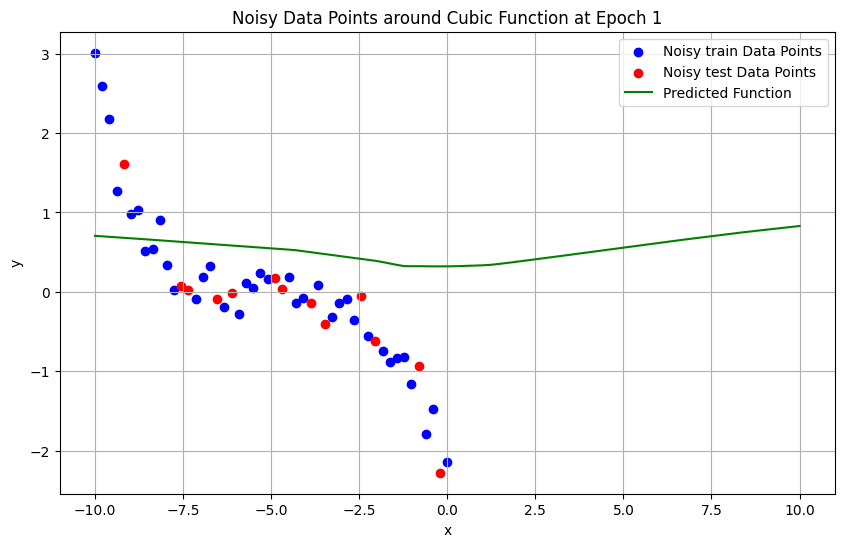

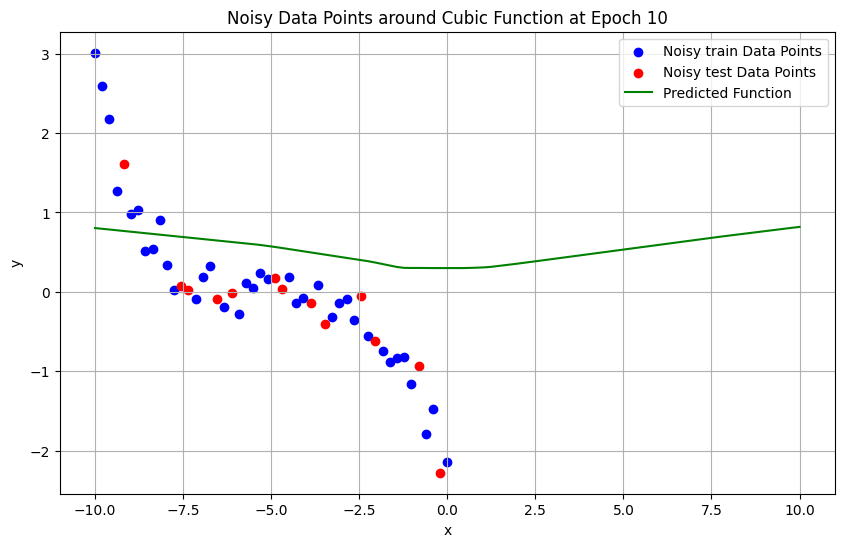

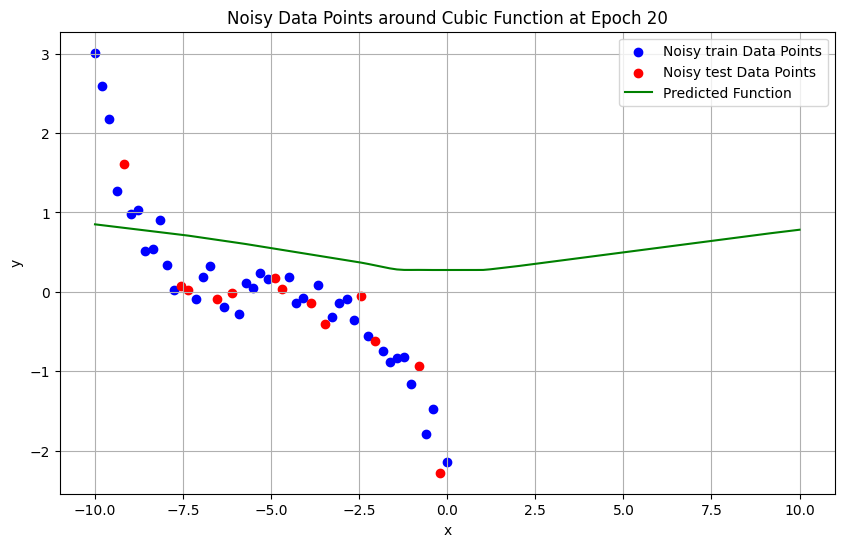

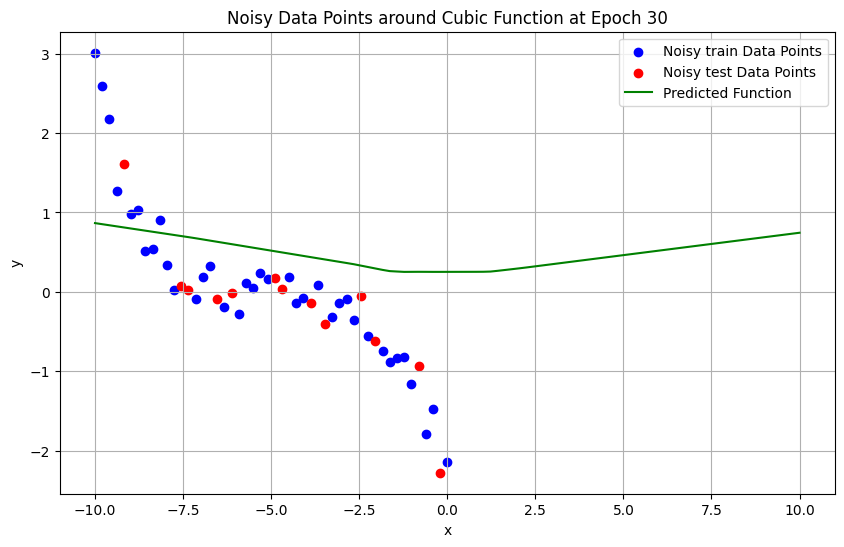

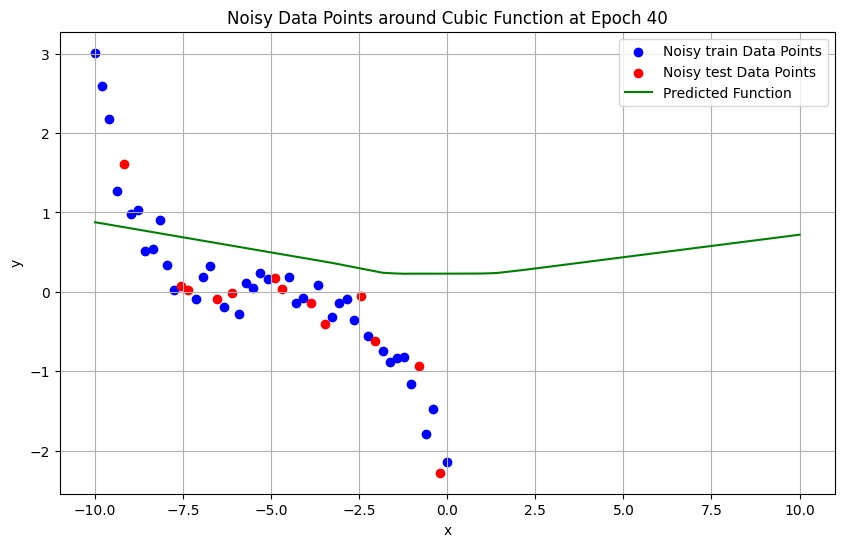

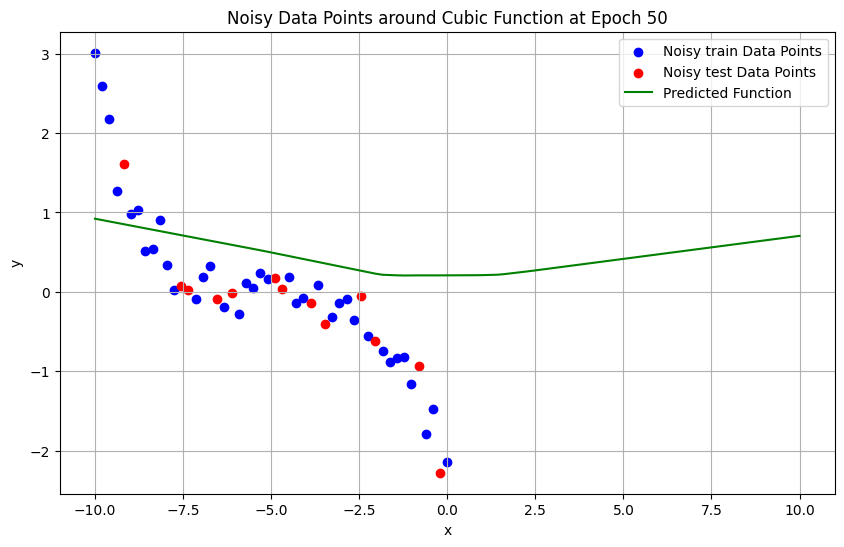

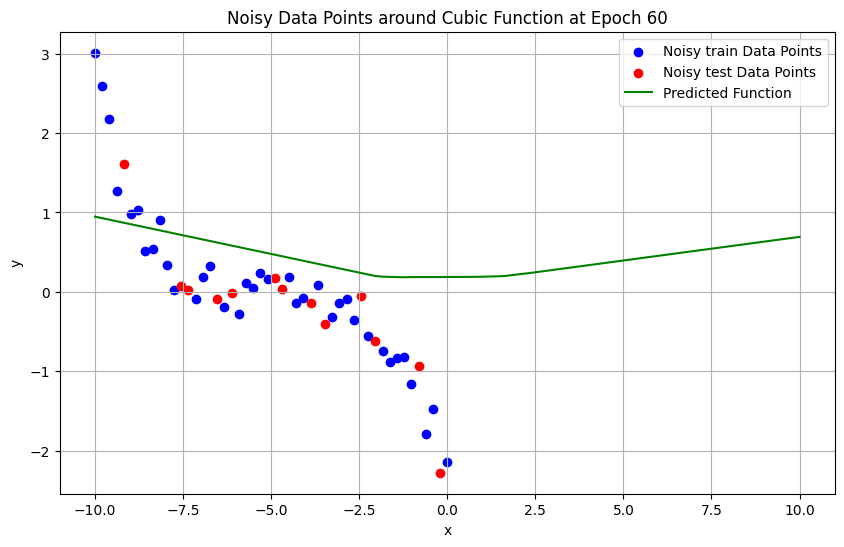

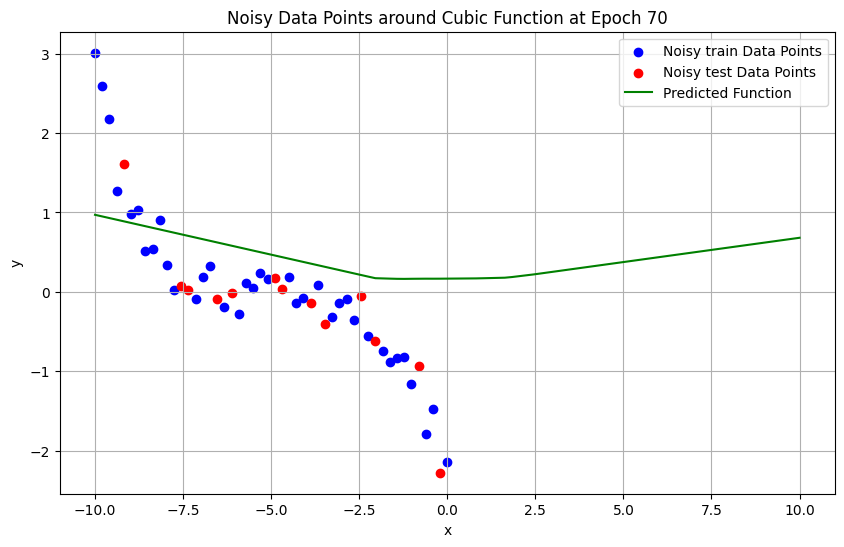

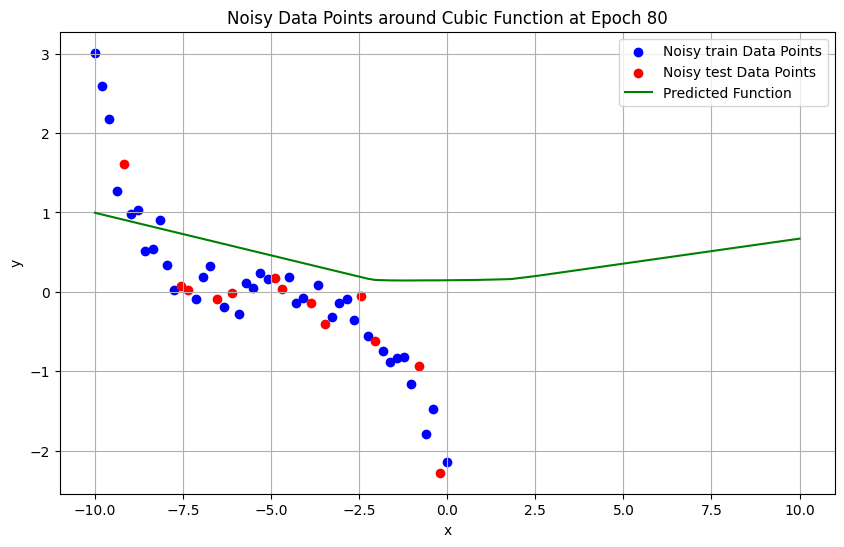

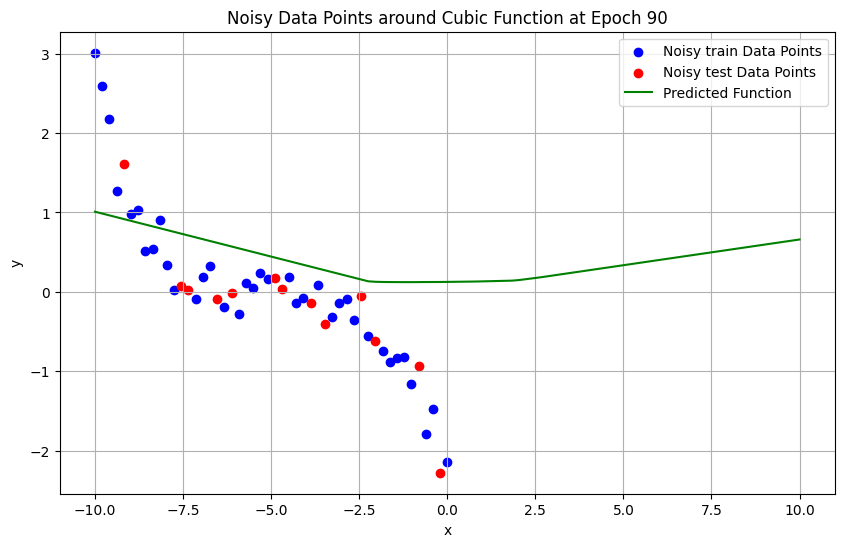

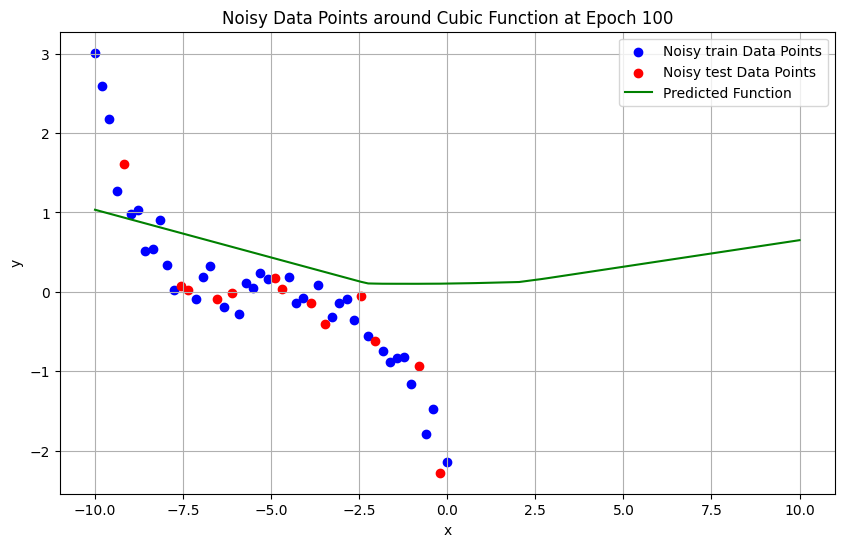

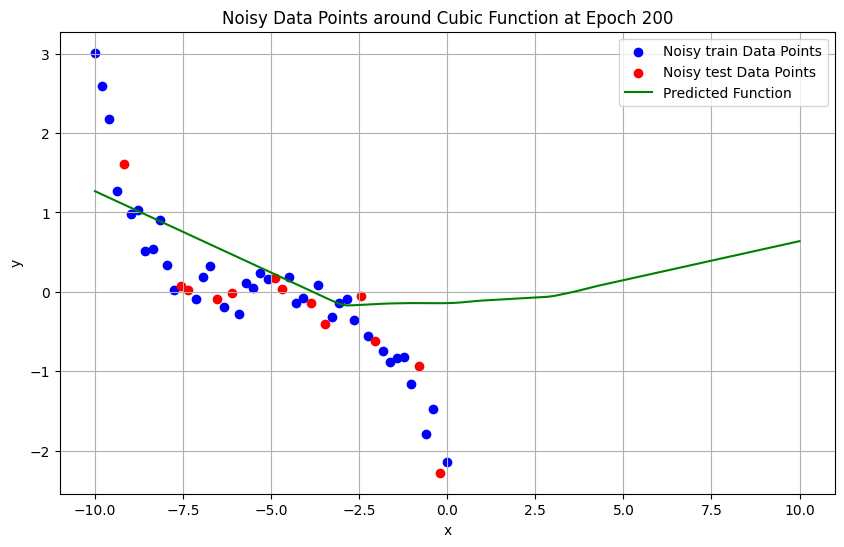

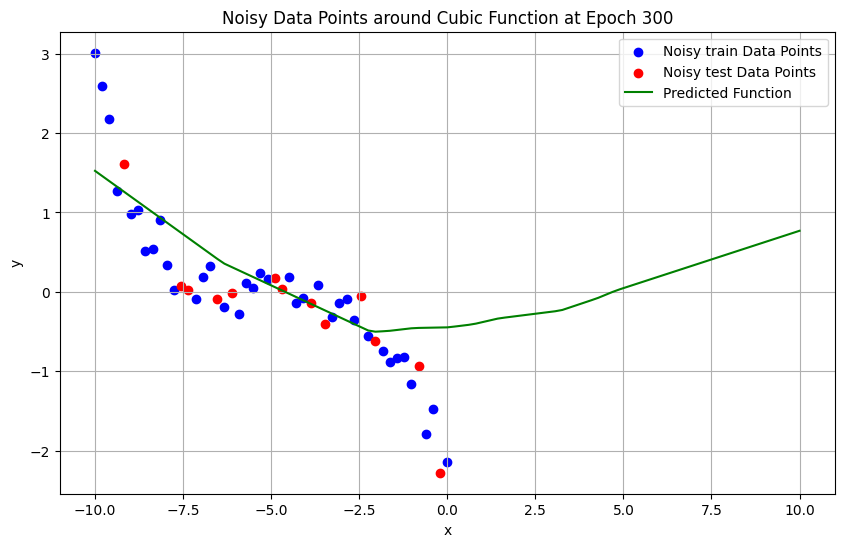

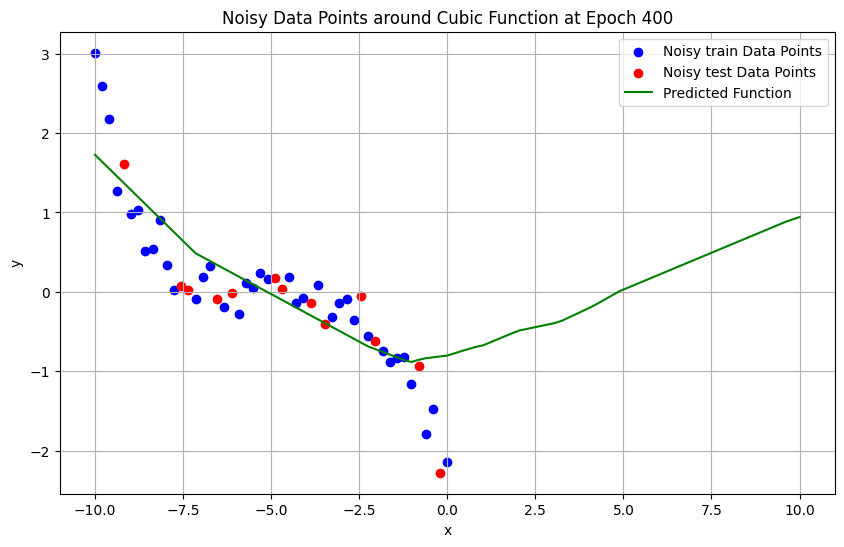

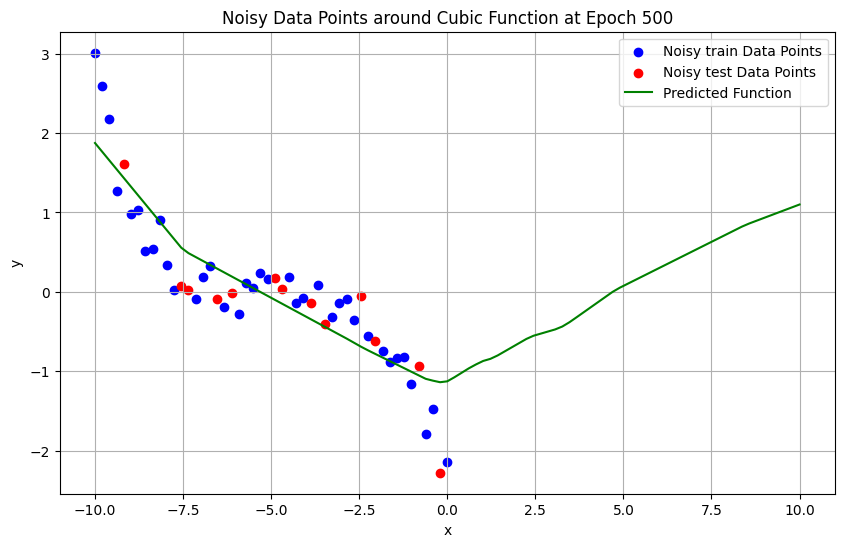

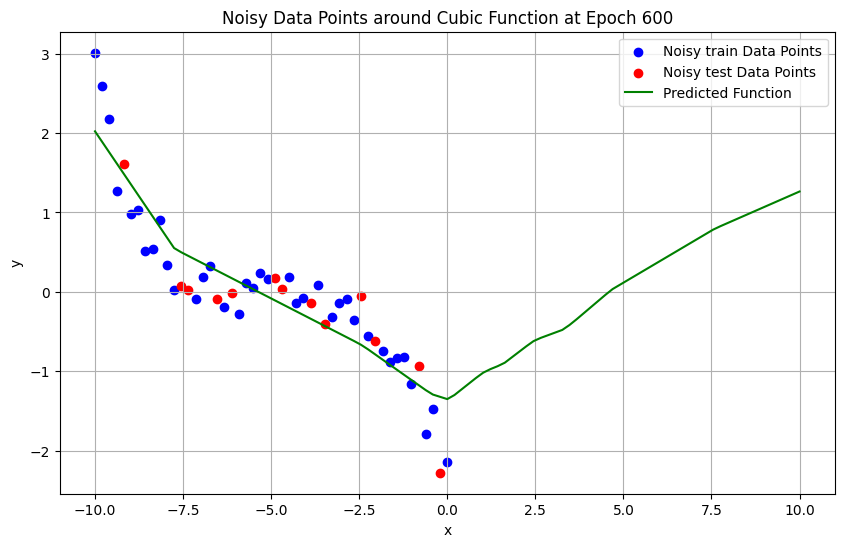

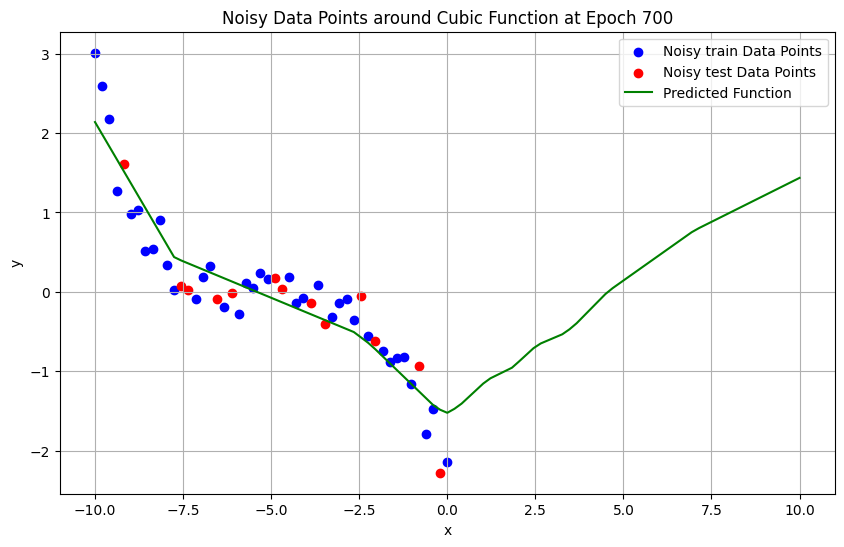

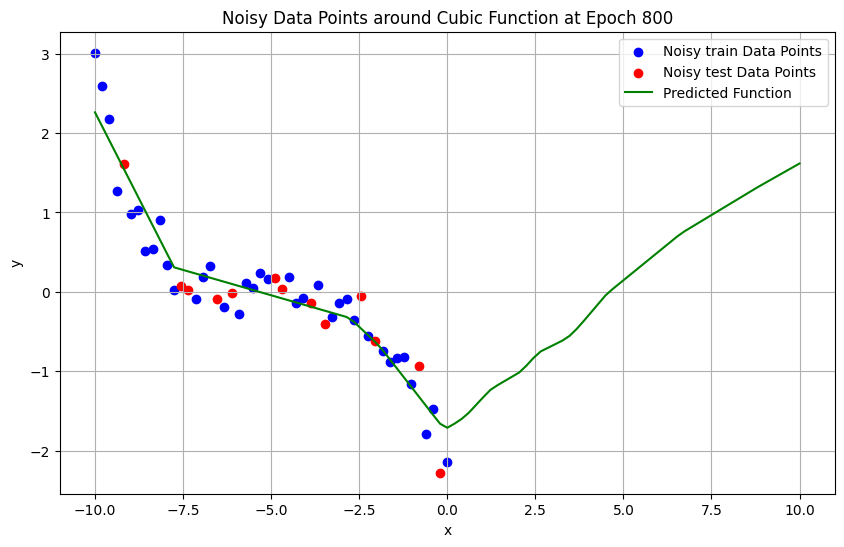

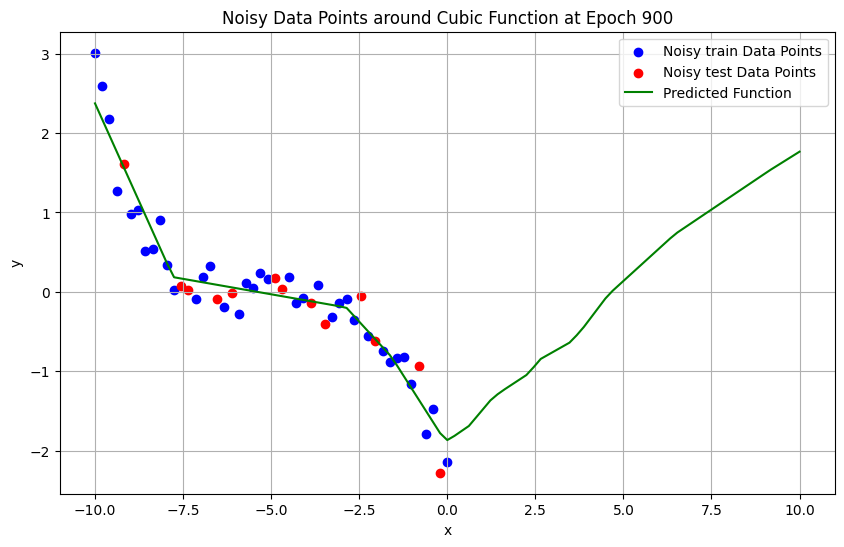

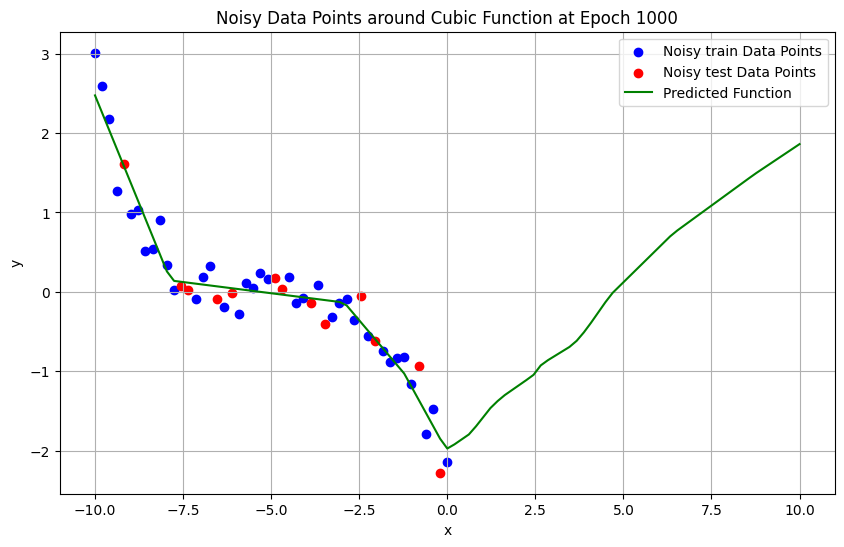

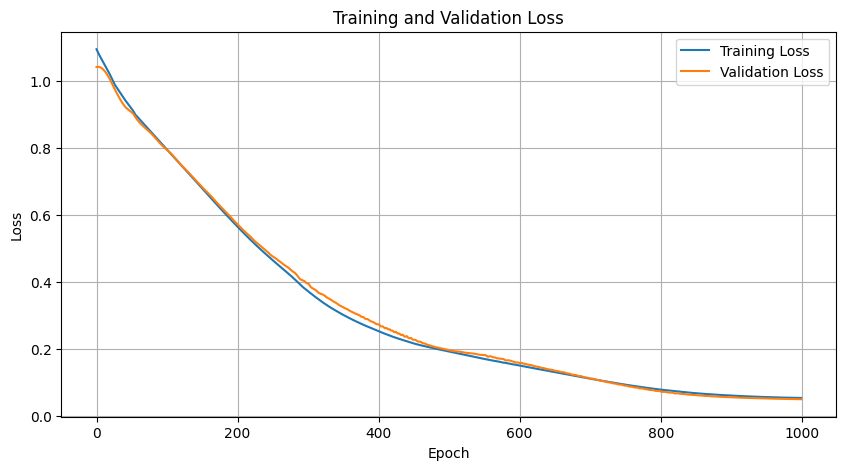

[I 2024-06-12 16:43:35,175] A new study created in memory with name: no-name-a5319307-28d1-4db9-b278-2d33aeed354e
[I 2024-06-12 16:43:43,841] Trial 0 finished with value: 15.090210914611816 and parameters: {'ewc-hp': 38728.52070009243}. Best is trial 0 with value: 15.090210914611816.
[I 2024-06-12 16:43:52,017] Trial 1 finished with value: 15.096264839172363 and parameters: {'ewc-hp': 38674.98805858402}. Best is trial 0 with value: 15.090210914611816.
[I 2024-06-12 16:44:00,562] Trial 2 finished with value: 15.054633140563965 and parameters: {'ewc-hp': 26908.799521222627}. Best is trial 2 with value: 15.054633140563965.
[I 2024-06-12 16:44:08,750] Trial 3 finished with value: 14.967043113708495 and parameters: {'ewc-hp': 12334.790295179355}. Best is trial 3 with value: 14.967043113708495.
[I 2024-06-12 16:44:16,967] Trial 4 finished with value: 15.036291885375977 and parameters: {'ewc-hp': 63442.156732300136}. Best is trial 3 with value: 14.967043113708495.


ewc_loss :0.0
loss before: 0.39454928040504456
loss after: 0.39454928040504456
ewc_loss :1.550562700458613e-08
loss before: 0.3842860162258148
loss after: 0.38447728753089905
ewc_loss :4.3708972441436345e-08
loss before: 0.37467145919799805
loss after: 0.37521061301231384
ewc_loss :8.349199021040477e-08
loss before: 0.36568230390548706
loss after: 0.36671215295791626
ewc_loss :1.3077664107186138e-07
loss before: 0.3571202754974365
loss after: 0.3587333858013153
ewc_loss :1.820656621021044e-07
loss before: 0.34928688406944275
loss after: 0.35153263807296753
ewc_loss :2.3468568599582795e-07
loss before: 0.34222814440727234
loss after: 0.34512293338775635
ewc_loss :2.868045498871652e-07
loss before: 0.3358098566532135
loss after: 0.3393475413322449
ewc_loss :3.365835823387897e-07
loss before: 0.33000341057777405
loss after: 0.3341551125049591
ewc_loss :3.8181275385795743e-07
loss before: 0.32479754090309143
loss after: 0.32950711250305176
ewc_loss :4.205772370369232e-07
loss before: 0.319

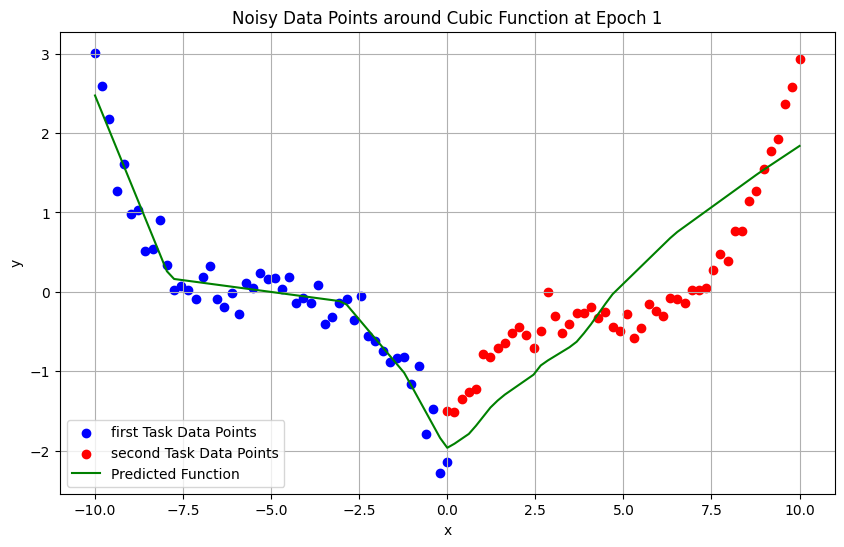

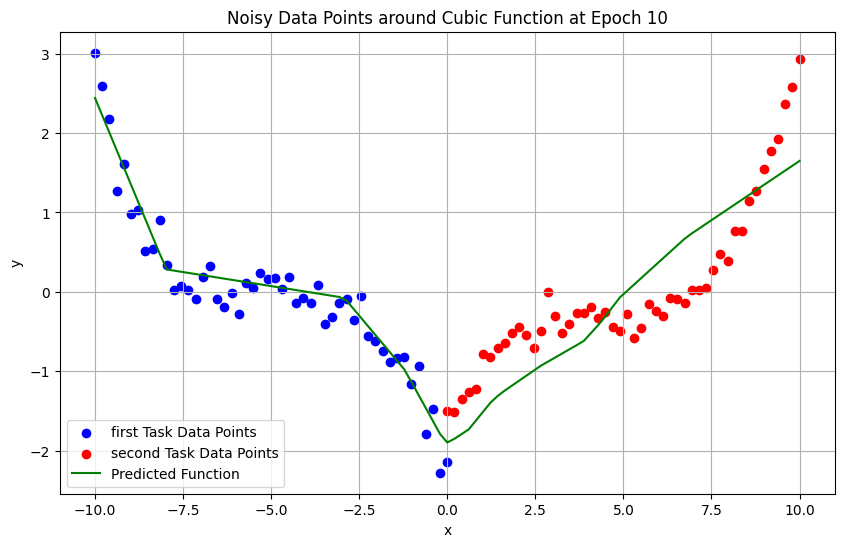

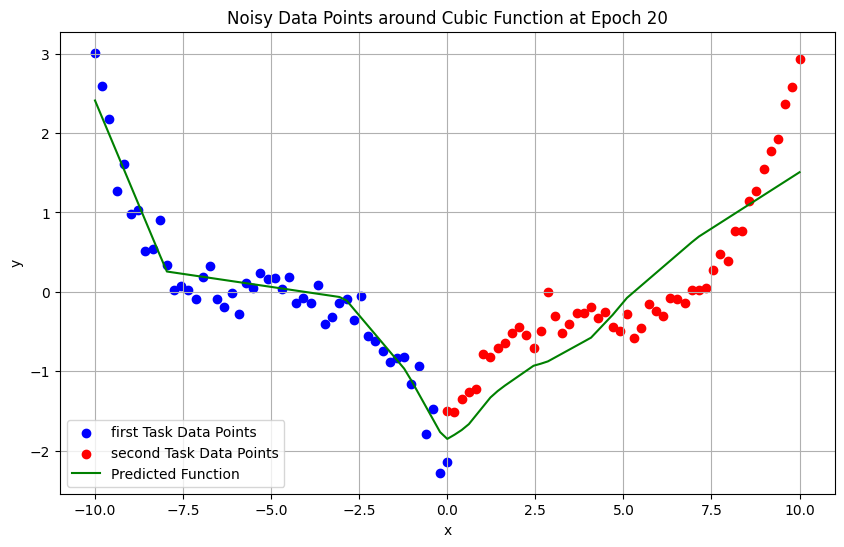

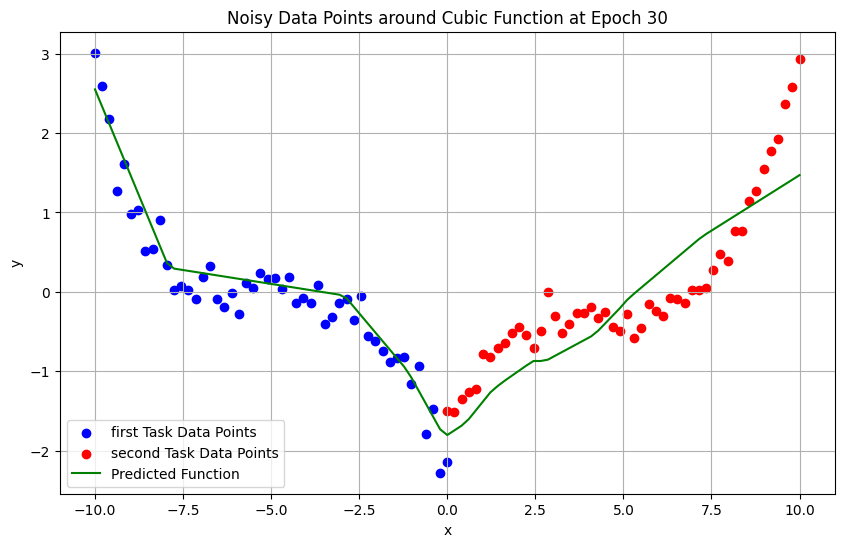

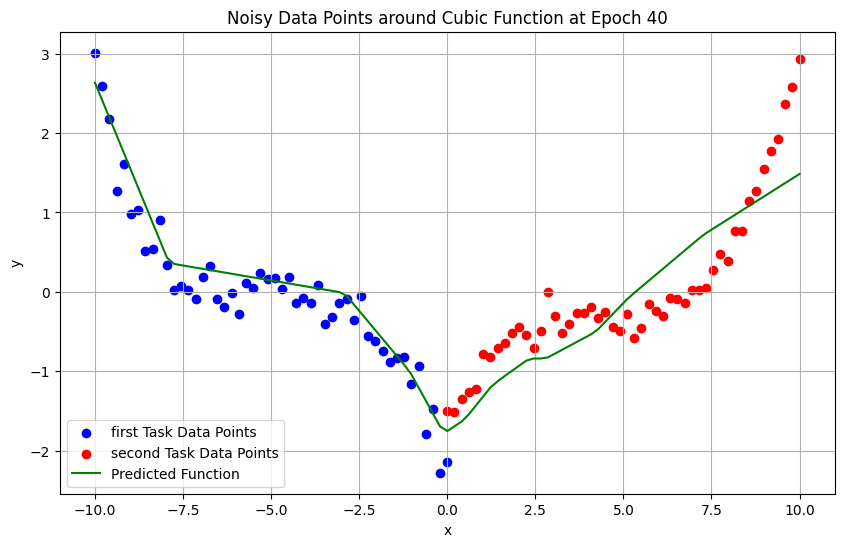

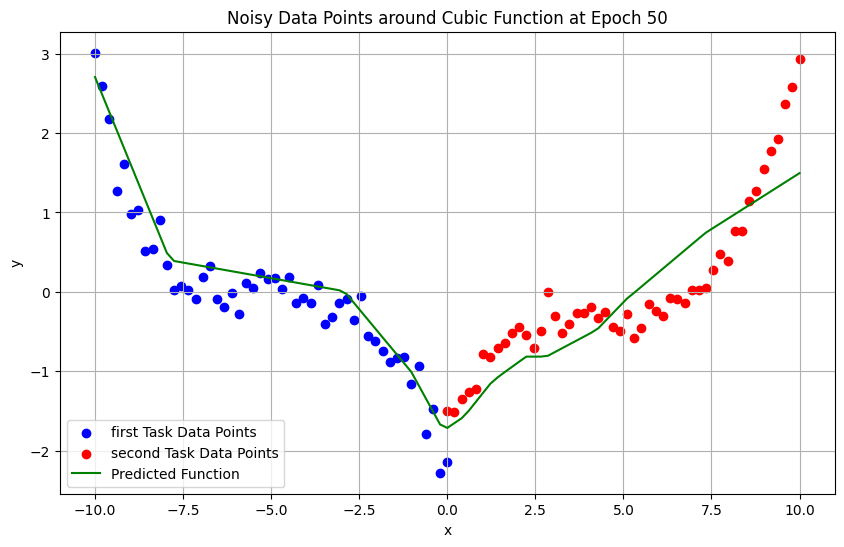

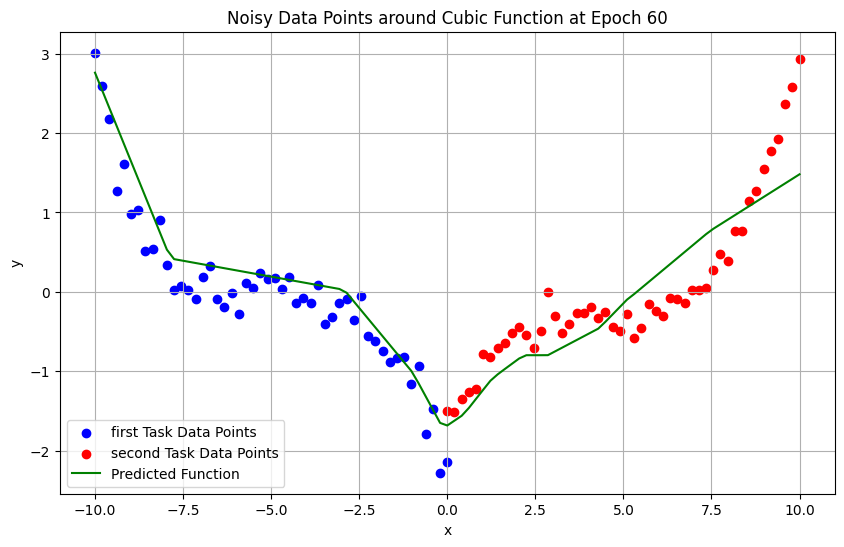

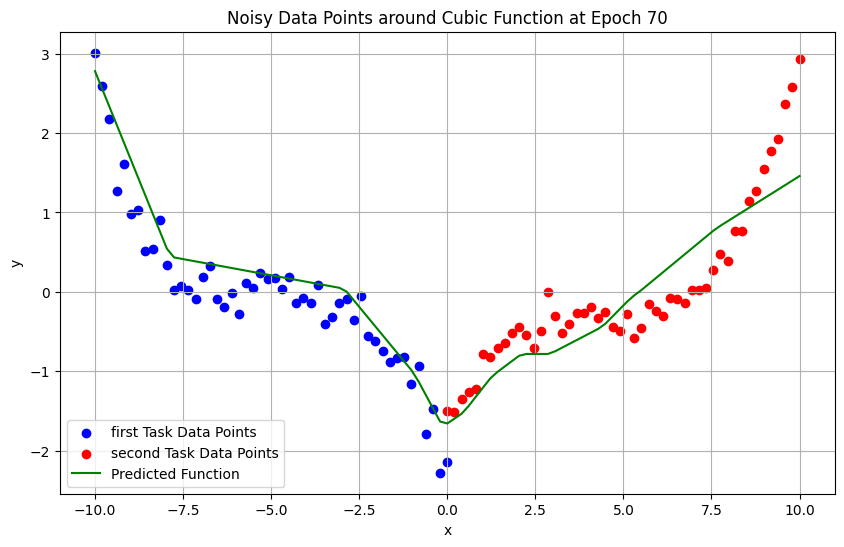

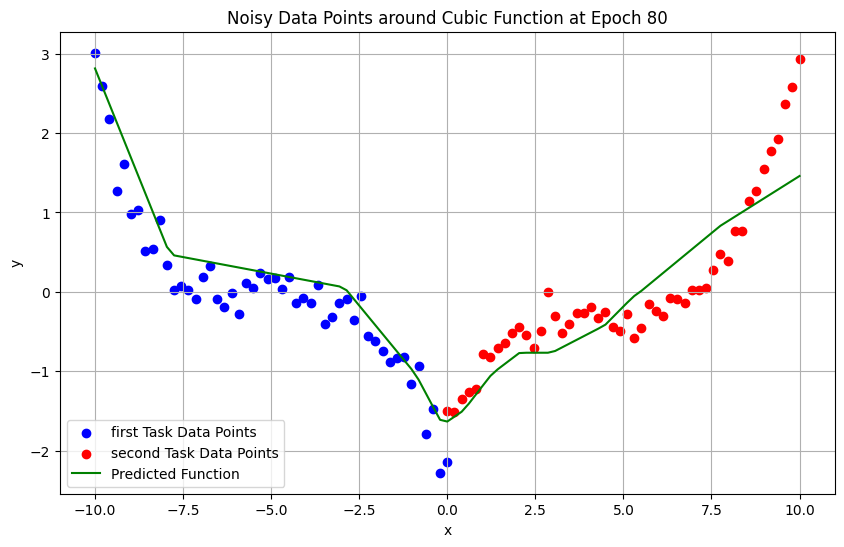

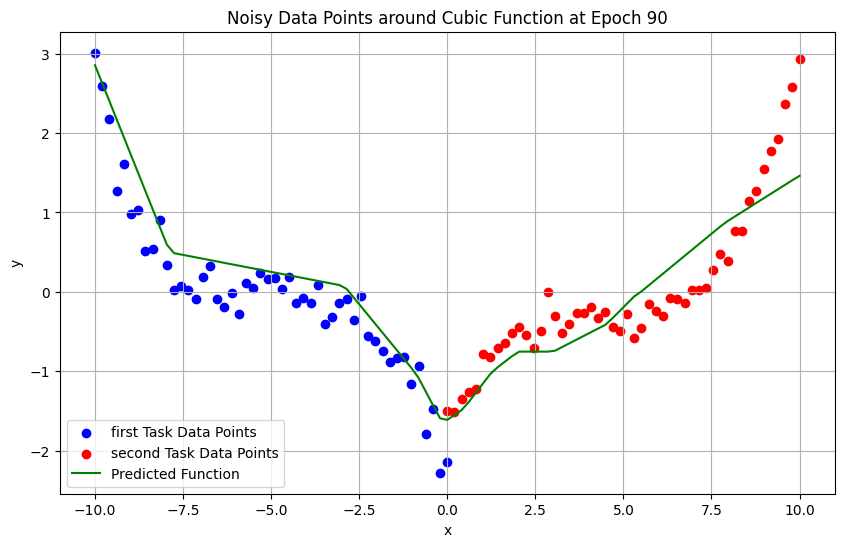

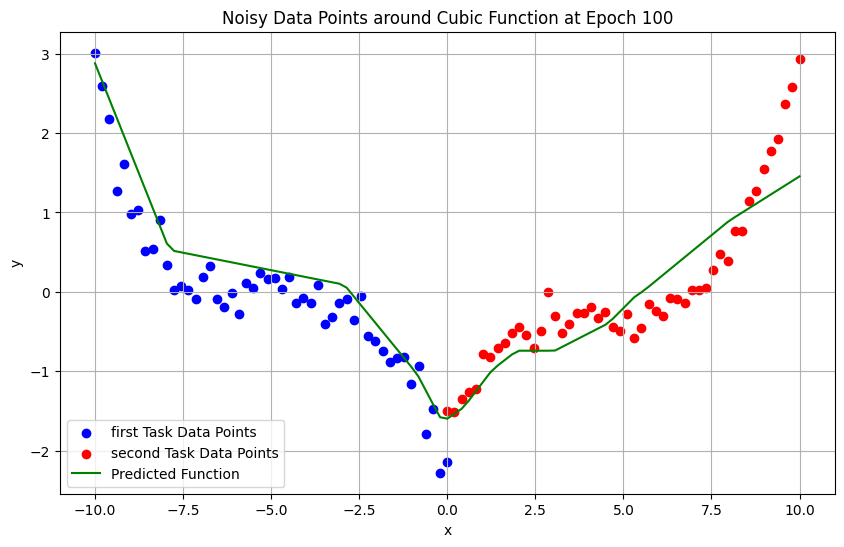

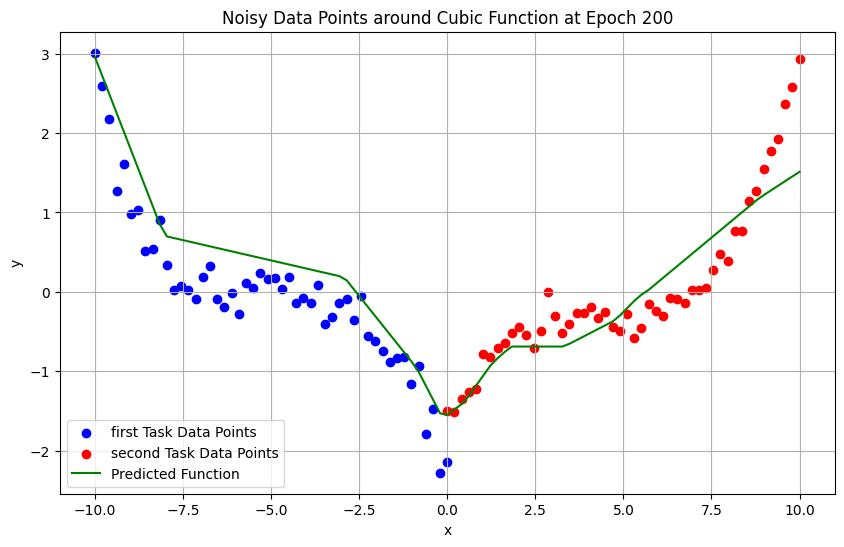

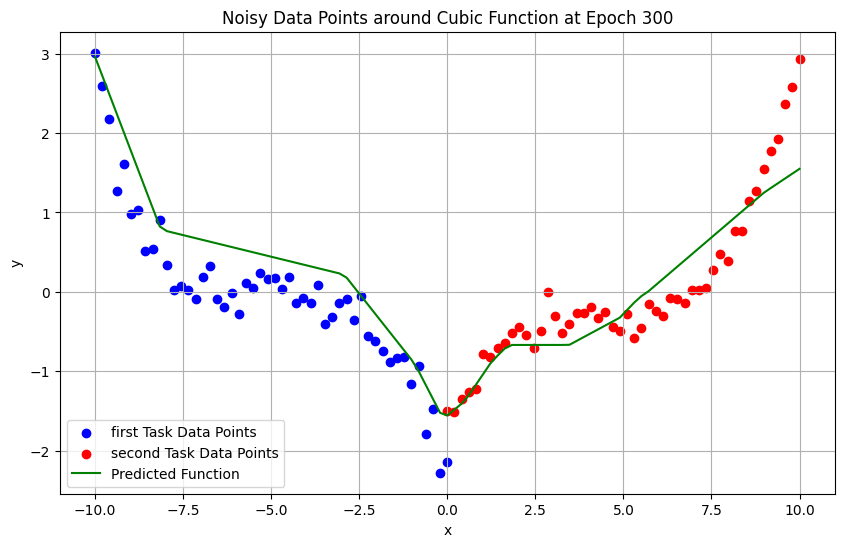

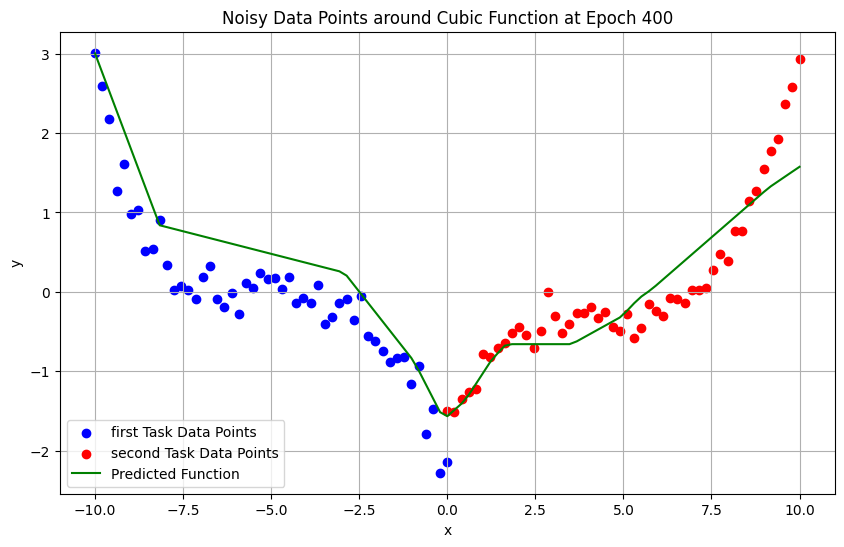

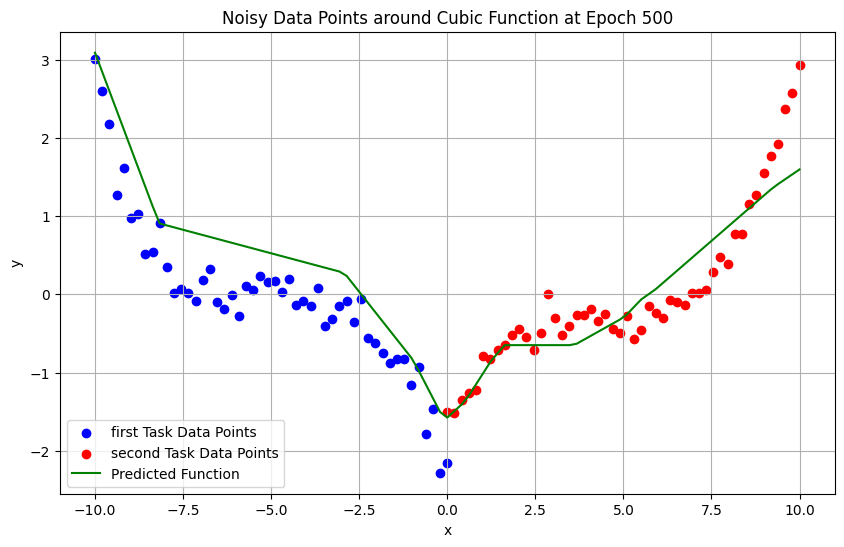

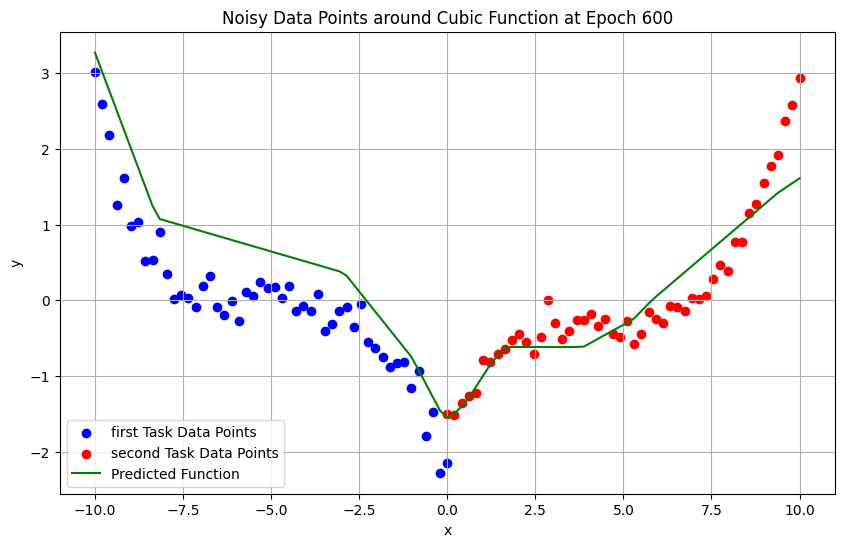

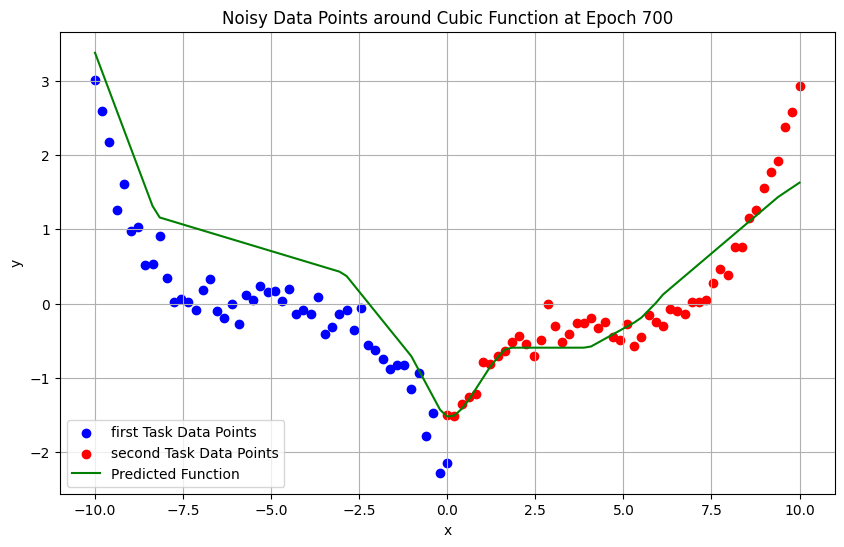

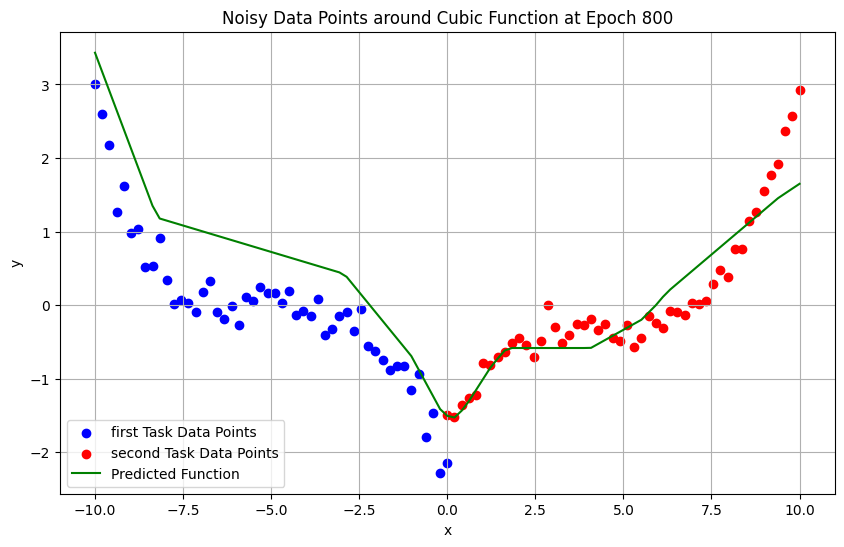

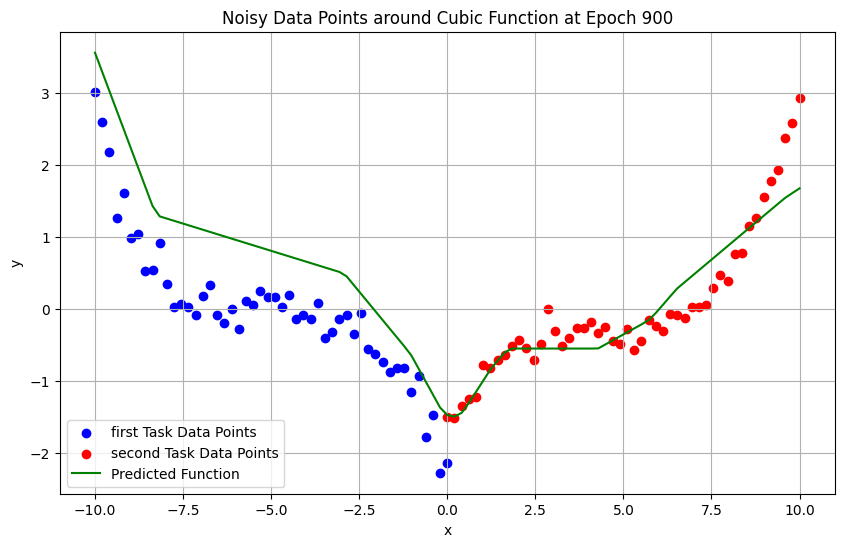

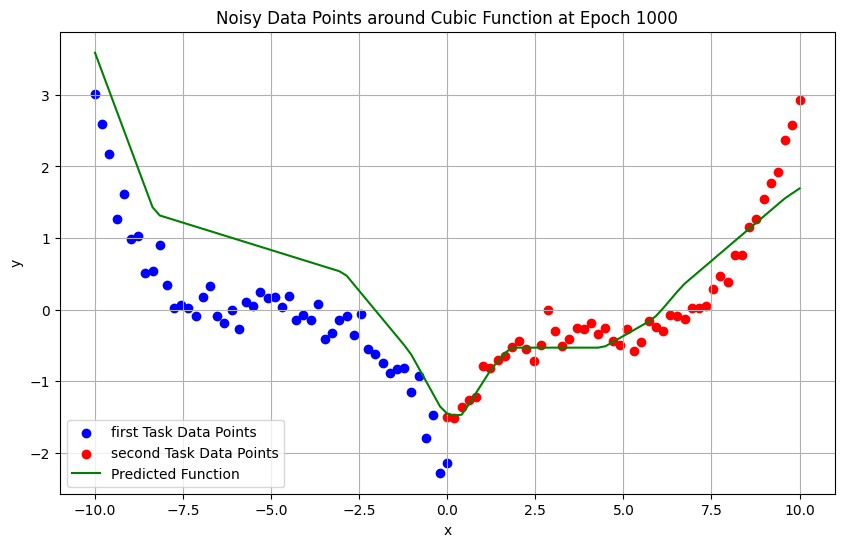

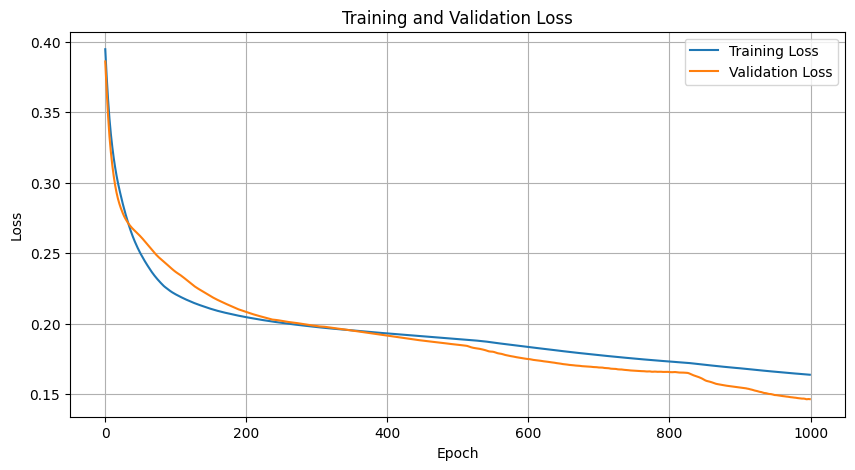

In [10]:
# Generate data
dataset = DataSet.data_generator(data_size=50, noise_std=20.5, seed=42)

# study = optuna.create_study(direction='minimize')
# study.optimize(Objective(False), n_trials=100)

# best_params = study.best_params
# best_value = study.best_value

# best_lr = study.best_params['lr']
# best_num_layers = study.best_params['num_layers']
# best_layer_nodes = [study.best_params[f'layer_{i}_nodes'] for i in range(best_num_layers)]

# Initial training phase
model = DynamicLinearRegression(best_num_layers, best_layer_nodes)
model = train_model_with_ewc(model, dataset, ewc=None, lr=best_lr)


# Save the model (example checkpoint save)
torch.save({
    'lr': best_lr, 
    'num_layer': best_num_layers,
    'layer_nodes': best_layer_nodes,
    'state_dict': model.state_dict(),
    'optimizer': optim.Adam(model.parameters()).state_dict()
}, 'first_half_trained_model.pt')

ewc = EWC(model, [(dataset.x1.unsqueeze(1), dataset.y1.unsqueeze(1))])

study2 = optuna.create_study(direction='minimize')
study2.optimize(TuneEwcObjective(dataset.x2, dataset.y2, ewc, 'first_half_trained_model.pt', dataset, True), n_trials=5)

best_value = study2.best_value

best_ewc_hp = study2.best_params['ewc-hp']

# Continue training with another dataset
#model = train_model_with_ewc(model, dataset, ewc=ewc, lr=best_lr, lambda_ewc=10000)
continue_training_with_ewc('first_half_trained_model.pt', dataset, ewc, lambda_ewc=best_ewc_hp)